# PROGETTO FINALE IDS

## Analisi e Predizione dei Risultati del Campionato di Serie A 2023/2024

**Obiettivo:** Analizzare i dati della stagione 2023/2024 di Serie A e costruire un modello per predire i risultati delle ultime 5 giornate.

In questo progetto, utilizzeremo un dataset contenente i risultati delle partite della stagione di calcio della Serie A 2023/2024 per predire l'esito delle ultime 5 giornate (dalla 33ª alla 38ª).

### Dettagli del Progetto
Il campionato di Serie A prevede 20 squadre e 38 giornate. Ogni squadra disputa una partita per giornata.
Il nostro focus è sulle **ultime 5 giornate**, che comprendono un totale di **50 partite** (10 partite per giornata × 5 giornate).

Per ciascuna di queste 50 partite, cercheremo di prevedere il risultato utilizzando uno dei seguenti esiti:

- **1**: Vittoria della squadra di casa
- **X**: Pareggio
- **2**: Vittoria della squadra in trasferta

In [30]:
# Importazione delle librerie necessarie
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats  # Per test statistici
import sklearn              # Per metriche di valutazione (es. confusion matrix)
import seaborn as sns       # Per visualizzazioni avanzate (es. heatmap)

## 1. Preparazione e Pulizia dei Dati (Data Wrangling)

In questa fase, caricheremo il dataset, lo ispezioneremo e lo puliremo rimuovendo colonne irrilevanti e trasformando i dati in un formato più adatto all'analisi.

Importiamo il file `Serie A_matches_23_24.csv`, che contiene i risultati di tutte le partite del campionato fino alla data di creazione del dataset. Visualizziamo le prime righe per familiarizzare con la struttura dei dati.

In [31]:
# Caricamento del dataset
matches = pd.read_csv('dataset/Serie A_matches_23_24.csv')

# Visualizzazione delle prime 5 righe
matches.head()

,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1,1,Empoli,Hellas Verona,2023-08-19T16:30:00Z,True,True,False,False,0_1,Full-Time,NaN,NaN,NaN,NaN
1,1,1,Frosinone,Napoli,2023-08-19T16:30:00Z,True,True,False,False,1_3,Full-Time,NaN,NaN,NaN,NaN
2,1,1,Genoa,Fiorentina,2023-08-19T18:45:00Z,True,True,False,False,1_4,Full-Time,NaN,NaN,NaN,NaN
3,1,1,Inter,Monza,2023-08-19T18:45:00Z,True,True,False,False,2_0,Full-Time,NaN,NaN,NaN,NaN
4,1,1,Roma,Salernitana,2023-08-20T16:30:00Z,True,True,False,False,2_2,Full-Time,NaN,NaN,NaN,NaN


### Pulizia dei Dati

Analizziamo le colonne presenti nel dataset e identifichiamo quelle che non sono necessarie per la nostra analisi predittiva:
- Le colonne `Unnamed: xx` sembrano essere artefatti dell'esportazione e non contengono informazioni utili.
- `Round Name` è ridondante rispetto a `Round`.
- `UTC Time`, `Finished`, `Started`, `Cancelled`, `Awarded`, `Match Status` contengono metadati sulla partita che non useremo direttamente nel modello basato sui gol.

In [32]:
# Elenco delle colonne da rimuovere
drop_columns = [
    'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', # Colonne vuote/inutili
    'Round Name',      # Ridondante
    'UTC Time',        # Dettagli temporali non usati
    'Finished',        # Stato partita non usato
    'Started',         # Stato partita non usato
    'Cancelled',       # Stato partita non usato
    'Awarded',         # Stato partita non usato
    'Match Status'     # Stato partita non usato
]

# Rimozione delle colonne specificate (inplace=True modifica il DataFrame direttamente)
matches.drop(drop_columns, axis=1, inplace=True)

# Visualizzazione delle prime righe dopo la rimozione
matches.head()

,Round,Home Team,Away Team,Score
0,1,Empoli,Hellas Verona,0_1
1,1,Frosinone,Napoli,1_3
2,1,Genoa,Fiorentina,1_4
3,1,Inter,Monza,2_0
4,1,Roma,Salernitana,2_2


In [33]:
# Verifica della presenza di valori nulli (NaN) per colonna
print("Valori nulli per colonna:")
matches.isnull().sum()

Valori nulli per colonna:


Round        0
Home Team    0
Away Team    0
Score        0
dtype: int64

### Trasformazione dei Dati

La colonna `Score` contiene il punteggio finale come stringa (es. "2_1"). Per facilitare l'analisi numerica, la suddividiamo in due colonne distinte:
- **Score_casa**: Gol segnati dalla squadra di casa.
- **Score_trasferta**: Gol segnati dalla squadra in trasferta.

Successivamente, rimuoviamo la colonna `Score` originale.

In [34]:
# Suddivisione della colonna 'Score' in 'Score_casa' e 'Score_trasferta'
# expand=True crea nuove colonne, str.split('_') divide sulla base del carattere '_'
# .astype(int) converte i risultati in numeri interi
matches[['Score_casa', 'Score_trasferta']] = matches['Score'].str.split('_', expand=True).astype(int)

# Rimozione della colonna 'Score' originale
matches.drop('Score', axis=1, inplace=True)

# Visualizzazione delle prime righe con le nuove colonne
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta
0,1,Empoli,Hellas Verona,0,1
1,1,Frosinone,Napoli,1,3
2,1,Genoa,Fiorentina,1,4
3,1,Inter,Monza,2,0
4,1,Roma,Salernitana,2,2


### Creazione della Variabile Target

Definiamo la colonna `Risultato`, che rappresenta la variabile che vogliamo predire (la nostra *variabile target*). Questa colonna conterrà uno dei tre possibili esiti:
- **'1'**: Vittoria della squadra di casa (`Score_casa` > `Score_trasferta`)
- **'X'**: Pareggio (`Score_casa` == `Score_trasferta`)
- **'2'**: Vittoria della squadra in trasferta (`Score_casa` < `Score_trasferta`)

In [35]:
# Creazione della colonna 'Risultato' basata sui punteggi
# Usiamo .loc per assegnare valori basati su condizioni booleane
matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'

# Visualizzazione delle prime righe con la colonna 'Risultato'
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Empoli,Hellas Verona,0,1,2
1,1,Frosinone,Napoli,1,3,2
2,1,Genoa,Fiorentina,1,4,2
3,1,Inter,Monza,2,0,1
4,1,Roma,Salernitana,2,2,X


Il nostro dataset è ora pulito e strutturato, pronto per le fasi successive di analisi esplorativa e modellazione.

## 2. Analisi Esplorativa dei Dati (EDA)

### Analisi Offensiva e Difensiva delle Squadre

Esaminiamo il rendimento offensivo (gol fatti) e difensivo (gol subiti) di ciascuna squadra nel corso della stagione. Questo ci aiuterà a identificare le squadre più prolifiche e quelle con le difese più solide, fattori chiave per la predizione dei risultati.

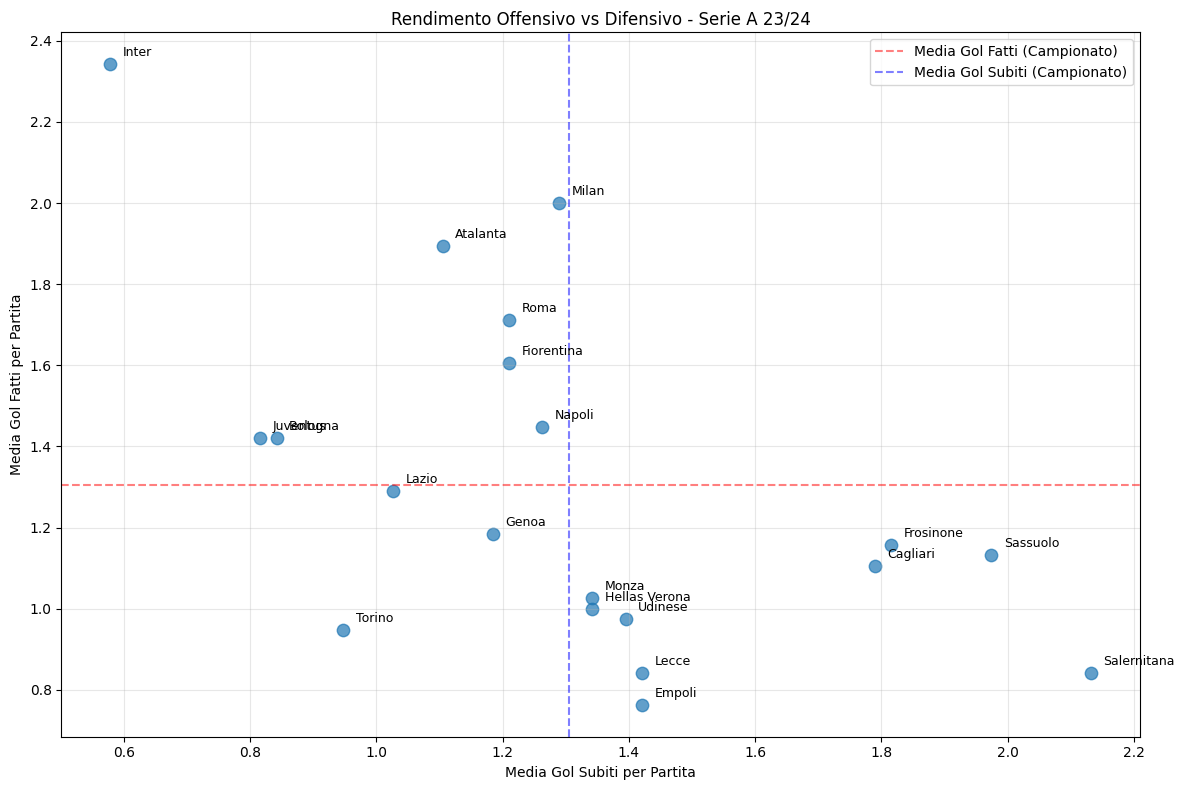

In [36]:
# --- Analisi Offensiva e Difensiva ---

# Calcolo statistiche aggregate per le partite in casa
home_stats = matches.groupby('Home Team').agg(
    gol_fatti_casa=('Score_casa', 'sum'),         # Somma gol fatti in casa
    gol_subiti_casa=('Score_trasferta', 'sum'),   # Somma gol subiti in casa
    partite_casa=('Round', 'count')               # Conteggio partite giocate in casa
).reset_index() # Converte l'indice (nome squadra) in colonna

# Calcolo statistiche aggregate per le partite in trasferta
away_stats = matches.groupby('Away Team').agg(
    gol_fatti_trasferta=('Score_trasferta', 'sum'), # Somma gol fatti in trasferta
    gol_subiti_trasferta=('Score_casa', 'sum'),    # Somma gol subiti in trasferta
    partite_trasferta=('Round', 'count')           # Conteggio partite giocate in trasferta
).reset_index()

# Unione dei due DataFrame (home_stats e away_stats) usando il nome della squadra
team_stats = pd.merge(
    home_stats,
    away_stats,
    left_on='Home Team',  # Colonna chiave nel DataFrame di sinistra
    right_on='Away Team', # Colonna chiave nel DataFrame di destra
    how='outer'           # 'outer' join per includere tutte le squadre
)

# Rinomina la colonna della squadra e rimuovi la colonna duplicata 'Away Team'
team_stats = team_stats.rename(columns={'Home Team': 'name'})
team_stats.drop('Away Team', axis=1, inplace=True)

# Calcolo delle medie gol fatti e subiti per partita (totale)
total_matches = team_stats['partite_casa'] + team_stats['partite_trasferta']
team_stats['Media_gol_fatti'] = (team_stats['gol_fatti_casa'] + team_stats['gol_fatti_trasferta']) / total_matches
team_stats['Media_gol_subiti'] = (team_stats['gol_subiti_casa'] + team_stats['gol_subiti_trasferta']) / total_matches

# --- Visualizzazione: Rendimento Offensivo vs Difensivo ---
plt.figure(figsize=(12, 8))
plt.scatter(team_stats['Media_gol_subiti'], team_stats['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiunta delle etichette con i nomi delle squadre vicino ai punti
for idx, row in team_stats.iterrows():
    plt.annotate(row['name'],
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02), # Leggero offset per leggibilità
                 fontsize=9)

# Aggiunta delle linee medie per riferimento
plt.axhline(y=team_stats['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.5, label='Media Gol Fatti (Campionato)')
plt.axvline(x=team_stats['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.5, label='Media Gol Subiti (Campionato)')

# Impostazione etichette, titolo e griglia
plt.xlabel('Media Gol Subiti per Partita')
plt.ylabel('Media Gol Fatti per Partita')
plt.title('Rendimento Offensivo vs Difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout() # Aggiusta layout per evitare sovrapposizioni
plt.show()

### Analisi del Fattore Campo

Il "fattore campo" è un concetto noto nel calcio: giocare nel proprio stadio, con il supporto del pubblico e senza dover viaggiare, può influenzare positivamente le prestazioni di una squadra. Analizziamo quanto questo fenomeno sia rilevante nella Serie A 2023/2024 confrontando i punti ottenuti in casa e in trasferta.

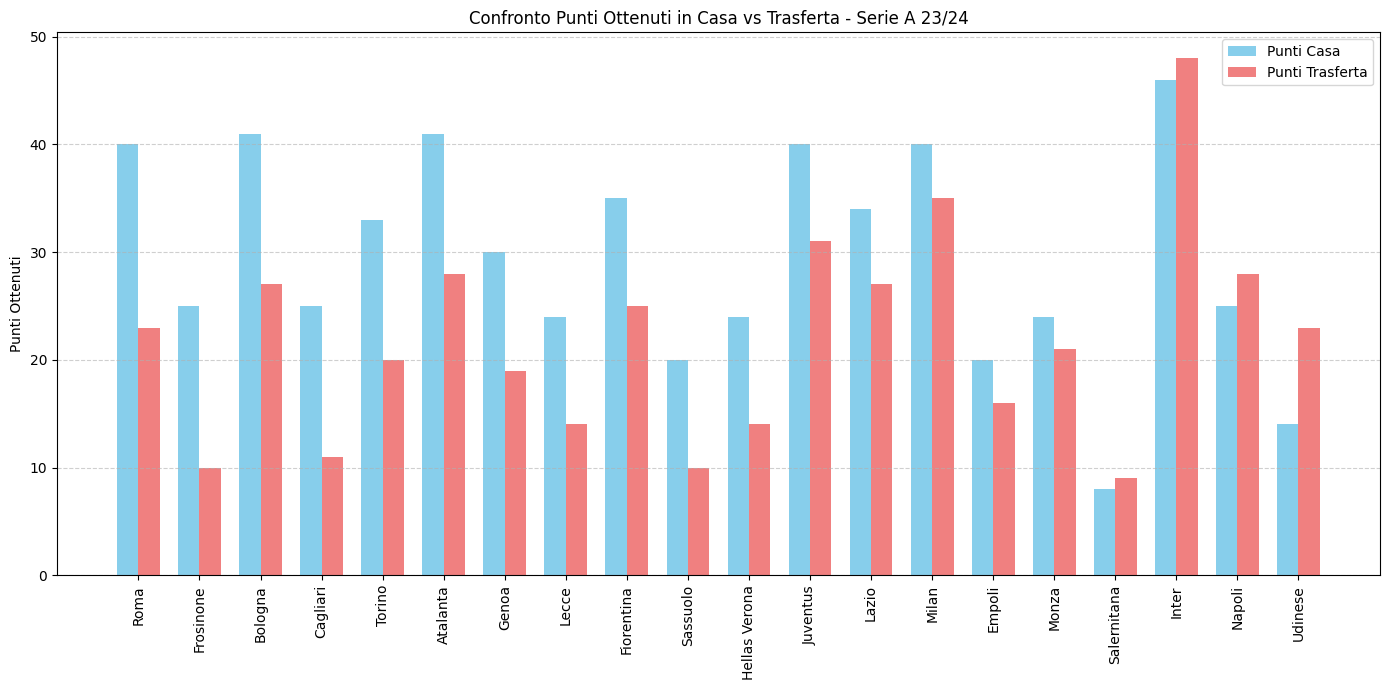

Tabella Riassuntiva - Punti Casa vs Trasferta (Ordinata per Differenza):


,name,points_home,points_away,points_diff
15,Roma,40,23,17
5,Frosinone,25,10,15
1,Bologna,41,27,14
2,Cagliari,25,11,14
18,Torino,33,20,13
0,Atalanta,41,28,13
6,Genoa,30,19,11
11,Lecce,24,14,10
4,Fiorentina,35,25,10
17,Sassuolo,20,10,10


In [37]:
# --- Analisi Rendimento Casa vs Trasferta ---

# Aggregazione dati per le partite giocate in casa
home_performance = matches.groupby('Home Team').agg(
    partite_casa=('Round', 'count'),
    # Uso di lambda per contare specifici risultati
    vittorie_casa=('Risultato', lambda x: (x == '1').sum()),
    pareggi_casa=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_casa=('Risultato', lambda x: (x == '2').sum()),
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
).reset_index()

# Aggregazione dati per le partite giocate in trasferta
away_performance = matches.groupby('Away Team').agg(
    partite_trasferta=('Round', 'count'),
    vittorie_trasferta=('Risultato', lambda x: (x == '2').sum()), # Vittoria trasferta = Risultato '2'
    pareggi_trasferta=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_trasferta=('Risultato', lambda x: (x == '1').sum()), # Sconfitta trasferta = Risultato '1'
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
).reset_index()

# Unione dei due DataFrame
home_vs_away = pd.merge(
    home_performance,
    away_performance,
    left_on='Home Team',
    right_on='Away Team',
    # suffixes=('', '_away') # Non necessario se rinominiamo subito
)
# Rinomina colonna squadra e rimuovi duplicato
home_vs_away = home_vs_away.rename(columns={'Home Team': 'name'})
home_vs_away.drop('Away Team', axis=1, inplace=True)

# Calcolo dei punti (3 punti per vittoria, 1 per pareggio)
home_vs_away['points_home'] = home_vs_away['vittorie_casa'] * 3 + home_vs_away['pareggi_casa']
home_vs_away['points_away'] = home_vs_away['vittorie_trasferta'] * 3 + home_vs_away['pareggi_trasferta']

# Calcolo della differenza di punti tra casa e trasferta
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento del DataFrame per differenza di punti (dal maggiore al minore)
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# --- Visualizzazione: Punti Casa vs Trasferta ---
N = len(home_vs_away_sorted) # Numero di squadre
ind = np.arange(N)           # Posizioni sull'asse X per le barre
width = 0.35                 # Larghezza delle barre

plt.figure(figsize=(14, 7))
# Barre per i punti in casa
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Punti Casa', color='skyblue')
# Barre per i punti in trasferta (con offset sull'asse X)
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Punti Trasferta', color='lightcoral')

# Impostazione etichette, titolo, legenda e tick sull'asse X
plt.ylabel('Punti Ottenuti')
plt.title('Confronto Punti Ottenuti in Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90) # Etichette squadre al centro delle coppie di barre
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Mostra la tabella riassuntiva ordinata
print("Tabella Riassuntiva - Punti Casa vs Trasferta (Ordinata per Differenza):")
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]

### Interpretazione del Grafico sul Fattore Campo

Il grafico a barre e la tabella mostrano chiaramente come varia il rendimento delle squadre tra le partite giocate in casa e quelle in trasferta:

- **Forte Vantaggio Casalingo**: Squadre come **Roma**, **Bologna**, e **Atalanta** evidenziano una differenza significativa, accumulando molti più punti nel proprio stadio. Questo può indicare una forte influenza del pubblico o un adattamento tattico specifico alle partite casalinghe.

- **Equilibrio Casa/Trasferta**: Squadre di vertice come **Inter**, **Milan**, e **Juventus** mostrano una maggiore consistenza, ottenendo un numero simile di punti sia in casa che fuori. Questa capacità di performare bene indipendentemente dal contesto è spesso un marchio delle squadre che lottano per il titolo.

- **Rendimento Superiore in Trasferta (Casi Rari)**: Alcune squadre potrebbero, in certi periodi, ottenere più punti in trasferta. Questo può dipendere da uno stile di gioco reattivo (contropiede) che funziona meglio contro squadre che attaccano di più in casa, o da difficoltà nel gestire la pressione delle partite casalinghe.

Queste differenze nel rendimento casa/trasferta sono cruciali e verranno considerate nel nostro modello predittivo.

### Distribuzione dei Risultati nel Campionato

Analizziamo la frequenza dei tre tipi di risultato (1, X, 2) sull'intero campione di partite giocate finora. Questo ci dà un'idea delle probabilità di base di ciascun esito nel campionato.

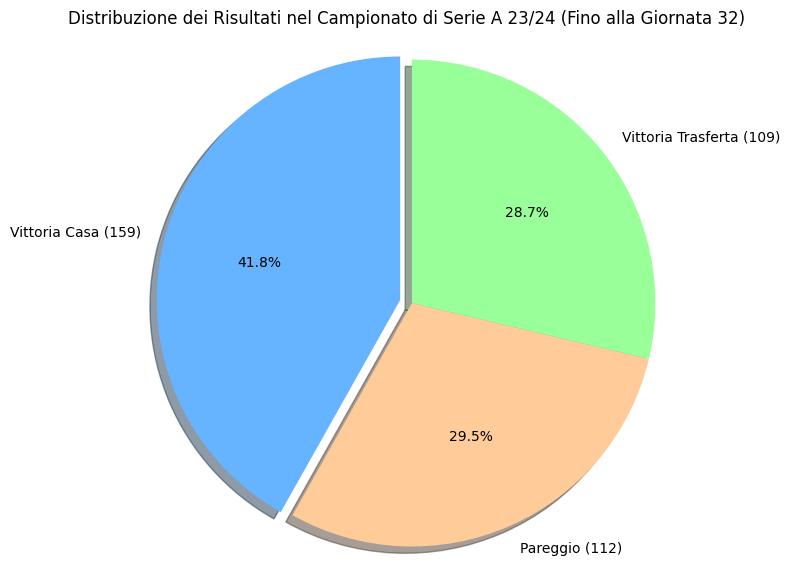

Riepilogo Risultati su 380 partite:
- Vittorie in casa (1): 159 (41.8%)
- Pareggi (X):          112 (29.5%)
- Vittorie trasferta (2): 109 (28.7%)


In [38]:
# Calcolo della frequenza di ciascun risultato ('1', 'X', '2')
risultati_count = matches['Risultato'].value_counts()

# --- Visualizzazione: Distribuzione Risultati (Grafico a Torta) ---
plt.figure(figsize=(10, 7))
labels = [f'Vittoria Casa ({risultati_count.get("1", 0)})', 
          f'Pareggio ({risultati_count.get("X", 0)})', 
          f'Vittoria Trasferta ({risultati_count.get("2", 0)})']
sizes = [risultati_count.get('1', 0), risultati_count.get('X', 0), risultati_count.get('2', 0)]
explode = (0.05, 0, 0)  # Enfatizza leggermente la fetta 'Vittoria Casa'
colors = ['#66b3ff', '#ffcc99', '#99ff99'] # Blu, Arancio, Verde

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', # Formato percentuale
        shadow=True, startangle=90)
plt.title('Distribuzione dei Risultati nel Campionato di Serie A 23/24 (Fino alla Giornata 32)')
plt.axis('equal') # Assicura che la torta sia circolare
plt.show()

# Stampa delle percentuali esatte
total_matches_played = len(matches)
print(f"Riepilogo Risultati su {total_matches_played} partite:")
print(f"- Vittorie in casa (1): {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/total_matches_played*100:.1f}%)")
print(f"- Pareggi (X):          {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/total_matches_played*100:.1f}%)")
print(f"- Vittorie trasferta (2): {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/total_matches_played*100:.1f}%)")

### Analisi Statistica del Fattore Campo (Test di Ipotesi)

Per confermare se il vantaggio casalingo osservato è statisticamente significativo, formuliamo un test di ipotesi:

- **H₀ (Ipotesi Nulla)**: Non c'è differenza significativa tra la probabilità di vittoria in casa e la probabilità di vittoria in trasferta. Le frequenze osservate sono dovute al caso.
- **H₁ (Ipotesi Alternativa)**: La probabilità di vittoria in casa è significativamente maggiore della probabilità di vittoria in trasferta. Il fattore campo ha un effetto reale.

Utilizzeremo un **test del Chi-Quadrato (χ²)** per confrontare le frequenze osservate delle vittorie casalinghe e in trasferta con quelle che ci aspetteremmo se l'ipotesi nulla fosse vera (cioè, 50% di vittorie casalinghe e 50% di vittorie in trasferta, *escludendo i pareggi*).

In [39]:
# --- Test Chi-Quadrato per il Fattore Campo ---

# Numero di vittorie in casa e in trasferta osservate
home_wins = risultati_count.get('1', 0)
away_wins = risultati_count.get('2', 0)

# Numero totale di partite con un vincitore (esclusi i pareggi)
total_decisive_matches = home_wins + away_wins

# Frequenze Osservate
observed_frequencies = [home_wins, away_wins]

# Frequenze Attese sotto H0 (nessuna differenza tra casa e trasferta)
# Ci aspettiamo che le vittorie si dividano equamente tra casa e trasferta
expected_frequencies = [total_decisive_matches / 2, total_decisive_matches / 2]

# Esecuzione del test Chi-Quadrato
# Confronta le frequenze osservate con quelle attese
chi2_statistic, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

# Livello di significatività (convenzionalmente 0.05)
alpha = 0.05

# Stampa dei risultati del test
print(f"--- Risultati del Test Chi-Quadrato (χ²) ---")
print(f"Partite decisive considerate (esclusi pareggi): {total_decisive_matches}")
print(f"Vittorie in casa osservate: {home_wins}")
print(f"Vittorie in trasferta osservate: {away_wins}")
print(f"Frequenze attese (sotto H0): {expected_frequencies[0]:.1f} casa, {expected_frequencies[1]:.1f} trasferta")
print(f"Statistica Chi-Quadrato (χ²): {chi2_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretazione del p-value
print("\nInterpretazione:")
if p_value < alpha:
    print(f"Poiché il p-value ({p_value:.4f}) è minore di alpha ({alpha}), rifiutiamo l'ipotesi nulla (H₀).")
    print("-> Esiste un'evidenza statistica significativa che suggerisce che le squadre di casa vincono più frequentemente delle squadre in trasferta in questo campionato.")
else:
    print(f"Poiché il p-value ({p_value:.4f}) non è minore di alpha ({alpha}), non possiamo rifiutiare l'ipotesi nulla (H₀).")
    print("-> Non c'è sufficiente evidenza statistica per concludere che le squadre di casa vincano più frequentemente di quelle in trasferta (basandosi su questo test).")

# Calcolo quantitativo del vantaggio del fattore campo (sulle partite decisive)
if total_decisive_matches > 0:
  home_win_prob_observed = home_wins / total_decisive_matches
  away_win_prob_observed = away_wins / total_decisive_matches
  home_advantage_pct = (home_win_prob_observed - 0.5) * 100 # Quanto la probabilità di vittoria in casa supera il 50%
  print(f"\nStima del Vantaggio Casalingo (su partite decisive): Le squadre di casa hanno vinto il {home_win_prob_observed:.1%} delle partite con un vincitore, circa {home_advantage_pct:.1f} punti percentuali in più rispetto al 50% atteso per caso.")

--- Risultati del Test Chi-Quadrato (χ²) ---
Partite decisive considerate (esclusi pareggi): 268
Vittorie in casa osservate: 159
Vittorie in trasferta osservate: 109
Frequenze attese (sotto H0): 134.0 casa, 134.0 trasferta
Statistica Chi-Quadrato (χ²): 9.3284
P-value: 0.0023

Interpretazione:
Poiché il p-value (0.0023) è minore di alpha (0.05), rifiutiamo l'ipotesi nulla (H₀).
-> Esiste un'evidenza statistica significativa che suggerisce che le squadre di casa vincono più frequentemente delle squadre in trasferta in questo campionato.

Stima del Vantaggio Casalingo (su partite decisive): Le squadre di casa hanno vinto il 59.3% delle partite con un vincitore, circa 9.3 punti percentuali in più rispetto al 50% atteso per caso.


## 3. Modello di Predizione Basato su Media Gol

Sviluppiamo ora un modello predittivo semplice ma informativo. L'idea è di utilizzare le statistiche storiche (medie gol fatti/subiti) delle squadre, differenziando tra prestazioni in casa e in trasferta, per stimare l'esito delle partite future.

**Logica del Modello:**
1.  **Calcolo Statistiche:** Si calcolano le medie di gol fatti e subiti per ogni squadra, separatamente per le partite giocate in casa e quelle in trasferta, utilizzando i dati delle prime 32 giornate (dati di *training*).
2.  **Stima Gol Attesi:** Per ogni partita delle ultime 5 giornate (dati di *test*), si stima il numero di gol che la squadra di casa potrebbe segnare e subire, e lo stesso per la squadra ospite, basandosi sulle medie calcolate.
    - *Gol attesi casa* = (Media gol fatti in casa dalla squadra di casa + Media gol subiti in trasferta dalla squadra ospite) / 2
    - *Gol attesi trasferta* = (Media gol fatti in trasferta dalla squadra ospite + Media gol subiti in casa dalla squadra di casa) / 2
3.  **Predizione Risultato:** Si calcola la differenza tra i gol attesi per la squadra di casa e quella ospite (`goal_diff = home_exp_goals - away_exp_goals`).
    - Se `goal_diff` supera una certa soglia positiva (`threshold_home`), si predice '1' (vittoria casa).
    - Se `goal_diff` è inferiore a una certa soglia negativa (`-threshold_away`), si predice '2' (vittoria trasferta).
    - Altrimenti (differenza vicina allo zero), si predice 'X' (pareggio).
4.  **Ottimizzazione Soglie:** I valori `threshold_home` e `threshold_away` sono parametri cruciali. Troveremo i valori ottimali che massimizzano l'accuratezza del modello sui dati di test utilizzando una ricerca a griglia (Grid Search).

In [40]:
from typing import Tuple, Dict, Any # Import per type hints

def predict_match_results(matches_df: pd.DataFrame, threshold_home: float, threshold_away: float) -> Tuple[pd.DataFrame, Dict[str, Dict[str, float]], float]:
    """
    Predice i risultati delle partite dalla giornata 33 in poi utilizzando
    le medie storiche dei gol fatti/subiti (fino alla giornata 32).
    
    Args:
        matches_df: DataFrame completo con i dati delle partite.
        threshold_home: Differenza minima di gol attesi per predire '1'.
        threshold_away: Differenza minima di gol attesi (in valore assoluto) per predire '2'.
    
    Returns:
        Tuple contenente:
        - DataFrame delle partite di test (giornate >= 33) con la colonna 'Prediction'.
        - Dizionario con le statistiche medie calcolate per ogni squadra.
        - Accuratezza complessiva del modello sul set di test.
    """
    # Divisione dei dati: training (giornate < 33), test (giornate >= 33)
    train_df = matches_df[matches_df["Round"] < 33].copy()
    test_df = matches_df[matches_df["Round"] >= 33].copy()
    
    # --- Calcolo Statistiche Medie sul Training Set ---
    teams = pd.unique(matches_df[['Home Team', 'Away Team']].values.ravel('K')) # Ottieni lista unica squadre
    team_stats: Dict[str, Dict[str, float]] = {}
    
    for team in teams:
        # Filtra partite in casa e trasferta per la squadra corrente nel training set
        home_matches = train_df[train_df['Home Team'] == team]
        away_matches = train_df[train_df['Away Team'] == team]
        
        # Calcola medie gol (gestendo il caso di 0 partite giocate)
        avg_home_scored = home_matches['Score_casa'].mean() if not home_matches.empty else 0
        avg_home_conceded = home_matches['Score_trasferta'].mean() if not home_matches.empty else 0
        avg_away_scored = away_matches['Score_trasferta'].mean() if not away_matches.empty else 0
        avg_away_conceded = away_matches['Score_casa'].mean() if not away_matches.empty else 0
        
        # Salva le statistiche nel dizionario
        team_stats[team] = {
            'avg_home_scored': avg_home_scored,
            'avg_home_conceded': avg_home_conceded,
            'avg_away_scored': avg_away_scored,
            'avg_away_conceded': avg_away_conceded
        }
    
    # --- Effettua Predizioni sul Test Set ---
    predictions = []
    
    for _, match in test_df.iterrows(): # Itera su ogni partita del test set
        home_team = match['Home Team']
        away_team = match['Away Team']
        
        # Recupera le statistiche medie per le due squadre
        home_stats = team_stats[home_team]
        away_stats = team_stats[away_team]
        
        # Stima i gol attesi basandosi sulle medie incrociate
        home_exp_goals = (home_stats['avg_home_scored'] + away_stats['avg_away_conceded']) / 2
        away_exp_goals = (away_stats['avg_away_scored'] + home_stats['avg_home_conceded']) / 2
        
        # Calcola la differenza di gol attesi
        goal_diff = home_exp_goals - away_exp_goals
        
        # Applica le soglie per determinare la predizione
        if goal_diff > threshold_home:
            prediction = '1'  # Vittoria casa predetta
        elif goal_diff < -threshold_away:
            prediction = '2'  # Vittoria trasferta predetta
        else:
            prediction = 'X'  # Pareggio predetto
            
        predictions.append(prediction)
    
    # Aggiungi la colonna delle predizioni al DataFrame di test
    test_df['Prediction'] = predictions
    
    # --- Calcolo Accuratezza ---
    # Confronta la colonna 'Risultato' (reale) con 'Prediction' (predetta)
    # .mean() su una serie booleana calcola la frazione di True (predizioni corrette)
    accuracy = (test_df['Risultato'] == test_df['Prediction']).mean() if not test_df.empty else 0
    # print(f"Accuratezza (th_home={threshold_home:.2f}, th_away={threshold_away:.2f}): {accuracy:.3f}") # Stampa opzionale per debug
    
    return test_df, team_stats, accuracy

In [41]:
# --- Ottimizzazione delle Soglie (Grid Search a Due Fasi) ---

best_acc = 0.0
best_threshold_home = 0.0 # Valore iniziale
best_threshold_away = 0.0 # Valore iniziale

# FASE 1: Ricerca Grossolana
# Esplora un range ampio di soglie con passi relativamente grandi (0.1)
print("--- FASE 1: Ricerca Grossolana (passo 0.1) ---")
coarse_threshold_range = np.arange(0.1, 1.0, 0.1) # Da 0.1 a 0.9
for th_home in coarse_threshold_range:
    for th_away in coarse_threshold_range:
        _, _, acc = predict_match_results(matches, threshold_home=th_home, threshold_away=th_away)
        # print(f"  Test: th_home={th_home:.1f}, th_away={th_away:.1f} -> Acc={acc:.3f}") # Stampa di debug
        # Aggiorna i migliori valori se l'accuratezza corrente è maggiore
        if acc > best_acc:
            best_acc = acc
            best_threshold_home = th_home
            best_threshold_away = th_away

print(f"\nMiglior risultato FASE 1: th_home={best_threshold_home:.1f}, th_away={best_threshold_away:.1f}, Accuratezza={best_acc:.3f}")

# FASE 2: Ricerca Fine
# Esplora un range più ristretto intorno ai migliori valori trovati nella Fase 1, con passi più piccoli (0.01)
print("\n--- FASE 2: Ricerca Fine (passo 0.01) ---")
# Definisci i range per la ricerca fine (es. +/- 0.1 rispetto al best_threshold con passo 0.01)
# Assicurati che i range rimangano entro limiti ragionevoli (es. > 0)
fine_home_start = max(0.01, best_threshold_home - 0.1)
fine_home_end = best_threshold_home + 0.1 + 0.001 # Aggiungi piccolo offset per includere l'estremo superiore
fine_away_start = max(0.01, best_threshold_away - 0.1)
fine_away_end = best_threshold_away + 0.1 + 0.001

fine_home_range = np.arange(fine_home_start, fine_home_end, 0.01)
fine_away_range = np.arange(fine_away_start, fine_away_end, 0.01)

best_acc_fine = best_acc # Inizia dal miglior risultato della fase 1
best_threshold_home_fine = best_threshold_home
best_threshold_away_fine = best_threshold_away

for th_home in fine_home_range:
    for th_away in fine_away_range:
        _, _, acc = predict_match_results(matches, threshold_home=th_home, threshold_away=th_away)
        # print(f"  Test: th_home={th_home:.2f}, th_away={th_away:.2f} -> Acc={acc:.3f}") # Stampa di debug
        # Aggiorna i migliori valori se l'accuratezza corrente è maggiore
        if acc > best_acc_fine:
            best_acc_fine = acc
            best_threshold_home_fine = th_home
            best_threshold_away_fine = th_away
        # Se l'accuratezza è uguale, potremmo preferire soglie più piccole o specifiche (opzionale)
        # elif acc == best_acc_fine:
            # Logica per spareggio (es. preferire soglie più piccole)
            # pass 

# Risultati finali dopo la ricerca fine
print(f"\nMiglior combinazione finale: th_home={best_threshold_home_fine:.2f}, th_away={best_threshold_away_fine:.2f}, Accuratezza={best_acc_fine:.3f}")

# Esegui la predizione finale con le soglie ottimali trovate
print("\nEsecuzione predizione finale con soglie ottimali...")
final_predictions_df, final_team_stats, final_accuracy = predict_match_results(
    matches,
    threshold_home=best_threshold_home_fine,
    threshold_away=best_threshold_away_fine
)
print(f"Accuratezza finale confermata: {final_accuracy:.3f}")

--- FASE 1: Ricerca Grossolana (passo 0.1) ---

Miglior risultato FASE 1: th_home=0.4, th_away=0.1, Accuratezza=0.517

--- FASE 2: Ricerca Fine (passo 0.01) ---

Miglior combinazione finale: th_home=0.44, th_away=0.10, Accuratezza=0.533

Esecuzione predizione finale con soglie ottimali...
Accuratezza finale confermata: 0.533


In [42]:
# --- Analisi dei Risultati della Predizione Finale ---

# Utilizziamo i risultati ottenuti con le soglie ottimali
predictions_df = final_predictions_df # Rinomina per chiarezza
optimal_th_home = best_threshold_home_fine
optimal_th_away = best_threshold_away_fine

# Visualizzazione dell'accuratezza per ciascuna giornata nel set di test
accuracy_by_round = predictions_df.groupby('Round').apply(
    lambda df: (df['Risultato'] == df['Prediction']).mean()
)
print("--- Accuratezza Media per Giornata (nel Test Set) ---")
print(accuracy_by_round)

# Visualizzazione dettagliata delle predizioni per una specifica giornata (es. l'ultima)
last_round_num = predictions_df['Round'].max()
last_round_df = predictions_df[predictions_df['Round'] == last_round_num]
print(f"\n--- Dettaglio Predizioni Giornata {last_round_num} (th_home={optimal_th_home:.2f}, th_away={optimal_th_away:.2f}) ---")
print(last_round_df[['Home Team', 'Away Team', 'Score_casa', 'Score_trasferta', 'Risultato', 'Prediction']])

--- Accuratezza Media per Giornata (nel Test Set) ---
Round
33    0.2
34    0.9
35    0.6
36    0.6
37    0.6
38    0.3
dtype: float64

--- Dettaglio Predizioni Giornata 38 (th_home=0.44, th_away=0.10) ---
         Home Team    Away Team  Score_casa  Score_trasferta Risultato  \
369       Cagliari   Fiorentina           2                3         2   
370          Genoa      Bologna           2                0         1   
371       Juventus        Monza           2                0         1   
372          Milan  Salernitana           3                3         X   
373       Atalanta       Torino           3                0         1   
374         Napoli        Lecce           0                0         X   
375         Empoli         Roma           2                1         1   
376      Frosinone      Udinese           0                1         2   
377  Hellas Verona        Inter           2                2         X   
378          Lazio     Sassuolo           1           

C:\Users\Mario\AppData\Local\Temp\ipykernel_7200\1550191797.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_round = predictions_df.groupby('Round').apply(


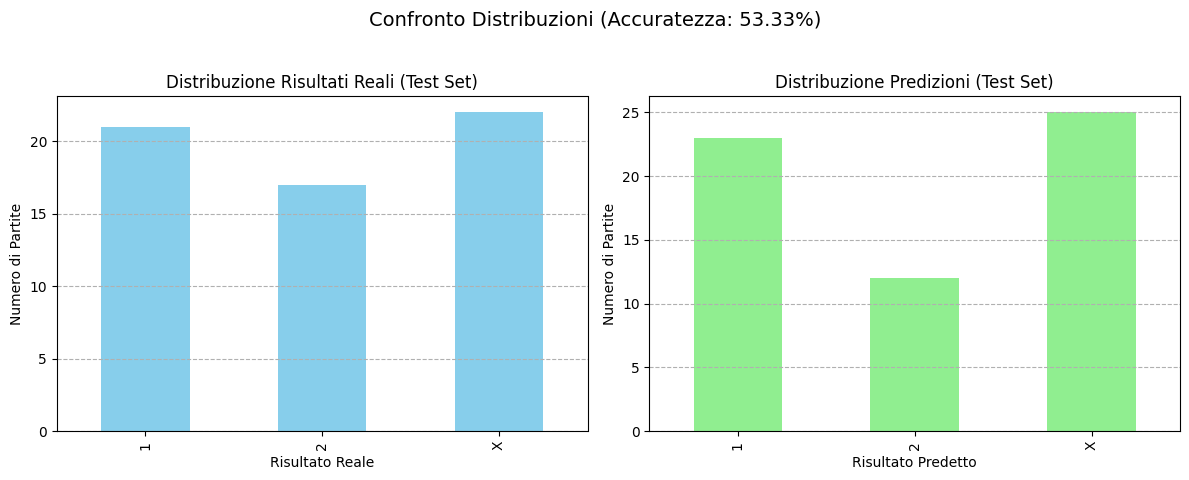


--- Report di Classificazione ---
              precision    recall  f1-score   support

           1       0.61      0.67      0.64        21
           X       0.48      0.55      0.51        22
           2       0.50      0.35      0.41        17

    accuracy                           0.53        60
   macro avg       0.53      0.52      0.52        60
weighted avg       0.53      0.53      0.53        60



In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# --- Valutazione Approfondita del Modello ---

# 1. Confronto Distribuzione Risultati Reali vs Predetti
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # Grafico 1 (sinistra)
real_counts = predictions_df['Risultato'].value_counts().sort_index()
real_counts.plot(kind='bar', color='skyblue', title='Distribuzione Risultati Reali (Test Set)')
plt.xlabel('Risultato Reale')
plt.ylabel('Numero di Partite')
plt.grid(axis='y', linestyle='--')

plt.subplot(1, 2, 2) # Grafico 2 (destra)
pred_counts = predictions_df['Prediction'].value_counts().sort_index()
pred_counts.plot(kind='bar', color='lightgreen', title='Distribuzione Predizioni (Test Set)')
plt.xlabel('Risultato Predetto')
plt.ylabel('Numero di Partite')
plt.grid(axis='y', linestyle='--')

plt.suptitle(f'Confronto Distribuzioni (Accuratezza: {final_accuracy:.2%})', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Aggiusta layout per titolo sovrapposto
plt.show()


# Report di Classificazione
# Fornisce metriche dettagliate (precision, recall, f1-score) per ciascuna classe
print("\n--- Report di Classificazione ---")
print(classification_report(predictions_df['Risultato'], predictions_df['Prediction'], labels=['1', 'X', '2'], zero_division=0))